# Model Agnosticism 

*Code to create Figure 3c in [Saliency Cards: A Framework to Characterize and Compare
Saliency Methods](https://arxiv.org/abs/2206.02958).*

Model agnosticism measures how much access to the model a saliency method requires. Model agnostic methods treat the underlying model as a black box, relying only on its input and output. On the other hand, model-dependent methods require access to model internals.

To illustrate model agnosticism, we show how [RISE](https://arxiv.org/pdf/1806.07421.pdf), a model agnostic method can be used to interpret two completely different model architectues: a CNN and a Random Forest.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms

from saliency_methods.rise import RISE
from saliency_methods.util import visualize_saliency

Define some user-specific paramters that will be used throughout the notebook.

In [3]:
DATA_DIR = '~/data/'

## RISE for an MNIST CNN

Using Pytorch we train a simple Convolutional Neural Network to classify MNIST images and apply the saliency method [RISE](https://arxiv.org/pdf/1806.07421.pdf) to interpret the results.

First, we load the [MNIST dataset in PyTorch](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html).

In [4]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(DATA_DIR, train=True, download=True, 
                               transform=transform)
test_dataset = datasets.MNIST(DATA_DIR, train=False, download=True, 
                              transform=transform)

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, 
                                           num_workers=1, pin_memory=True, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, 
                                          num_workers=1, pin_memory=True, 
                                          shuffle=False)

Next, we create a CNN model, following the PyTorch basic [MNIST CNN example](https://github.com/pytorch/examples/tree/main/mnist).

In [6]:
class Net(nn.Module):
    """Simple CNN model."""
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = Net().to(device)

We define the training and testing procedures and train the model.

In [8]:
def train(model, device, train_loader, optimizer, epoch):
    """Performs one training epoch."""
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    """Tests the model and prints the loss and accuracy."""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
optimizer = optim.Adadelta(cnn_model.parameters(), lr=1.0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

In [10]:
for epoch in range(1, 15):
    train(cnn_model, device, train_loader, optimizer, epoch)
    test(cnn_model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304075
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.290838

Test set: Average loss: 0.0525, Accuracy: 9821/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.060676
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.025788

Test set: Average loss: 0.0338, Accuracy: 9894/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.040387
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.040586

Test set: Average loss: 0.0296, Accuracy: 9900/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.026051
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.065485

Test set: Average loss: 0.0293, Accuracy: 9908/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.042140
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.018853

Test set: Average loss: 0.0275, Accuracy: 9907/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.012586
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.020024

Test set: Average loss: 0.0280, Accuracy: 9917/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.008461
Train Epoch: 7 [320

Apply RISE to MNIST examples and the trained model.

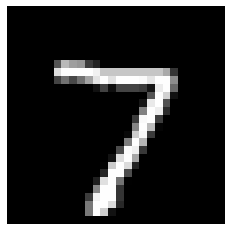

In [11]:
image, _ = test_dataset[0]
image_size = image.shape[1:]
image_batch = image.unsqueeze(0).to(device)
display_batch = image_batch.detach().cpu().numpy()
plt.imshow(image.squeeze(0), cmap='gray')
plt.axis('off');

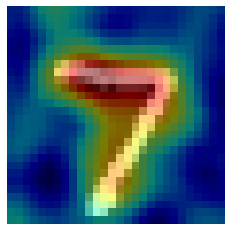

In [12]:
rise_cnn = RISE(cnn_model, image_size, 1000)
rise_cnn_saliency = rise_cnn.get_saliency(image_batch).squeeze(0)
visualize_saliency(rise_cnn_saliency, images=display_batch, scheme='heatmap', absolute_values=False, image_cmap='gray');

## RISE for an MNIST Random Forest Classifier

Now we do the same proceudre, but this time use SciKit Learn we train a Random Forest classifier on MNIST images and apply the saliency method [RISE](https://arxiv.org/pdf/1806.07421.pdf) to interpret the results.

First, we convert the MNIST data to SciKit Learn format.

In [13]:
def convert_pytorch_dataset(dataset):
    """Converts PyTorch Dataset object to SciKit Learn dataset format.
    
    Returns data, a 2D numpy array of the flattened dataset images, and targets,
    a 1D numpy array of the dataset labels.
    """
    data = []
    targets = []
    for image, label in dataset:
        flattened_image = image.detach().cpu().numpy().reshape(-1)
        data.append(flattened_image)
        targets.append(label)
    return np.array(data), np.array(targets)

train_data, train_targets = convert_pytorch_dataset(train_dataset)
test_data, test_targets = convert_pytorch_dataset(test_dataset)

Next, we train a [random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) on the data.

In [14]:
rf_model = RandomForestClassifier()
rf_model.fit(train_data, train_targets);

In [15]:
test_accuracy = rf_model.score(test_data, test_targets)
print(f'Random forest classifier acheives {test_accuracy:.2%} accuracy on MNIST.')

Random forest classifier acheives 97.04% accuracy on MNIST.


Finally, we run [RISE](https://arxiv.org/pdf/1806.07421.pdf) on the random forest classifier (a very different architecture than our prvious CNN model). This is only possible because RISE is model agnostic!

In [16]:
def rf_model_wrapper(image_batch):
    """Wraps the SciKit random forest model to work like a PyTorch model for 
    integration with the interpretability methods package."""
    rf_image_batch = image_batch.flatten(start_dim=1).detach().cpu().numpy()
    output = rf_model.predict_proba(rf_image_batch)
    tensor_output = torch.from_numpy(output.astype(np.float32)).to(device)
    return tensor_output

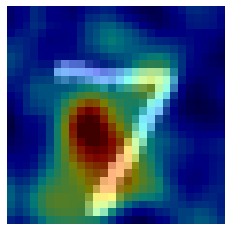

In [17]:
rise_rf = RISE(rf_model_wrapper, image_size, 1000)
rise_rf_saliency = rise_rf.get_saliency(image_batch).squeeze(0)
visualize_saliency(rise_rf_saliency, images=display_batch, scheme='heatmap', absolute_values=False, image_cmap='gray');